# DSI37 Capstone Project: Skin Disease Classification Using Computer Vision

<a id='part_iii'></a>
[Part I](Part1-Intro_Eda.ipynb#part_i) <br>
[Part II](Part2-EfficientnetModel.ipynb#part_ii) <br>
[Part IV](Part4-ResnetModel.ipynb#part_iv) <br>
[Part V](Part5-Ensemble_Insights_Recommendations.ipynb#part_v)

<a id='part_iii'></a>
# Part 3: Transfer Learning with VGG16

## Contents
[1. Importing Libraries](#imports) <br>
[2. Importing and Preprocessing Data](#data) <br>
[3. Hyperparameter Tuning](#hypertuning) <br>
[4. Model](#model) <br>
[5. Fine Tuning](#finetuning) <br>

<a id='imports'></a>
## 1. Importing Libraries

In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
# Pip install keras tuner
!pip install keras-tuner -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 4.0 MB/s eta 0:00:00


In [2]:
# Import required libraries
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
import keras
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2L
from tensorflow.keras.applications.resnet_v2 import ResNet152V2
from tensorflow.keras.applications.vgg16 import VGG16
import keras_tuner
from keras_tuner.tuners import BayesianOptimization
from keras import Model, layers
from keras.models import Sequential
from keras.optimizers import Adam, SGD
from keras.layers import GlobalAveragePooling2D, Dropout, Dense, Input, Conv2D, MaxPooling2D, Flatten
from keras import backend as K

<a id='data'></a>
## 2. Importing and Preprocessing Data

In [3]:
# Setting directories
cwd = '/content/drive/MyDrive/Colab Notebooks/Capstone 3'
data_dir = '/content/drive/MyDrive/Colab Notebooks/Capstone 3/data'
model_dir = '/content/drive/MyDrive/Colab Notebooks/Capstone 3/models'

In [4]:
# Setting batch size and image size
batch_size = 32
img_height = 224
img_width = 224

# Creating train dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    labels='inferred',
    label_mode='categorical',
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset='training'
)

# Create validation dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    labels='inferred',
    label_mode='categorical',
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset='validation'
)

Found 3265 files belonging to 5 classes.
Using 2612 files for training.
Found 3265 files belonging to 5 classes.
Using 653 files for validation.


In [5]:
# Get the class labels and number of classes from the dataset
class_labels = train_ds.class_names
num_classes = len(class_labels)
print('Class labels:', class_labels)
print("Number of classes:", num_classes)

# Create the inverse mapping of class indices to class labels
inv_map_classes = {i: label for i, label in enumerate(class_labels)}
map_classes = {label: i for i, label in enumerate(class_labels)}
print('Inverse mapping of classes:', inv_map_classes)
print('Mapping of classes:', map_classes)

Class labels: ['acne', 'eczema', 'fungal', 'psoriasis', 'warts']
Number of classes: 5
Inverse mapping of classes: {0: 'acne', 1: 'eczema', 2: 'fungal', 3: 'psoriasis', 4: 'warts'}
Mapping of classes: {'acne': 0, 'eczema': 1, 'fungal': 2, 'psoriasis': 3, 'warts': 4}


In [6]:
# Creating test dataset
val_batches = val_ds.cardinality()
test_ds = val_ds.take(val_batches // 5) # Moving 20% into test dataset
val_ds = val_ds.skip(val_batches // 5)
print('Number of validation batches: %d' % val_ds.cardinality())
print('Number of test batches: %d' % test_ds.cardinality())

Number of validation batches: 17
Number of test batches: 4


In [7]:
# Prepare all train/validation/test datasets
train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

<a id='hypertuning'></a>
## 3. Hyperparameter Tuning

In [ ]:
# Data augmentation
def create_augmentation(level):
  """This function accepts a string argument to determine the level of data augmentation to apply"""
  if level == 'medium':
    data_augmentation = tf.keras.Sequential([
        layers.RandomRotation(factor=0.15),
        layers.RandomContrast(factor=0.1)
    ])
    return data_augmentation
  elif level == 'hard':
    data_augmentation = tf.keras.Sequential([
        layers.RandomRotation(factor=0.15),
        layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
        layers.RandomContrast(factor=0.1)
      ])
    return data_augmentation
  else:
    data_augmentation = tf.keras.Sequential([
        layers.RandomRotation(factor=0.15)
    ])
    return data_augmentation

In [ ]:
# Modifying HyperModel subclass
class VGGHyperModel(keras_tuner.HyperModel):
    def build(self, hp):
      # Load base model
      base_model = VGG16(weights='imagenet',
                         include_top=False,
                         input_shape=(img_height, img_width, 3))

      # Freeze the base model weights
      base_model.trainable = False

      # Specify model architecture (Feature extraction)
      inputs = keras.Input(shape=(img_height, img_width, 3))
      x = keras.applications.vgg16.preprocess_input(inputs)
      # Tune Data Augmentation
      augment_level = hp.Choice('augment', ['soft', 'medium', 'hard'])
      x = create_augmentation(augment_level)(x)
      x = base_model(x, training=False)
      x = GlobalAveragePooling2D()(x)
      # Tune number of units in the Dense layer
      x = Dense(units=hp.Int('units_1', 128, 1280, step=128), activation='relu')(x)
      # Tune batch normalization
      if hp.Boolean('batch_norm'):
        x = layers.BatchNormalization()(x)
      # Tune dropout rate
      x = Dropout(hp.Float('dropout', min_value= 0.1, max_value=0.5, step= 0.1))(x)
      outputs = Dense(num_classes, activation='softmax')(x)
      model = Model(inputs, outputs)

      # Tune the optimizer
      optimizer = hp.Choice('optim', ['adam', 'sgd'])

      if optimizer=='sgd':
        optimizer = keras.optimizers.SGD(momentum=0.9, nesterov=True)
      else:
        optimizer = keras.optimizers.Adam()

      model.compile(optimizer=optimizer,
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

      # Tune learning rate
      learning_rate = hp.Float('lr', min_value=1e-4, max_value=1e-2, sampling='log')
      K.set_value(model.optimizer.learning_rate, learning_rate)

      return model

    def fit(self, hp, model, x, validation_data, *args, **kwargs):
        return model.fit(train_ds,
                         validation_data=val_ds,
                         *args,
                         **kwargs)

In [ ]:
# Specifying tuner settings
tuner = keras_tuner.tuners.BayesianOptimization(hypermodel=VGGHyperModel(),
                                                objective='val_accuracy',
                                                max_trials=20,
                                                overwrite=True,
                                                directory="/content/drive/MyDrive/Colab Notebooks/Capstone 3/vgghypermodel",
                                                project_name="/content/drive/MyDrive/Colab Notebooks/Capstone 3/vgghypermodel/bayesian")

In [ ]:
# Print summary of search space
tuner.search_space_summary()

Search space summary
Default search space size: 6
augment (Choice)
{'default': 'soft', 'conditions': [], 'values': ['soft', 'medium', 'hard'], 'ordered': False}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 128, 'max_value': 1280, 'step': 128, 'sampling': 'linear'}
batch_norm (Boolean)
{'default': False, 'conditions': []}
dropout (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
optim (Choice)
{'default': 'adam', 'conditions': [], 'values': ['adam', 'sgd'], 'ordered': False}
lr (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


In [ ]:
# Set earlystopping
earlystopping = EarlyStopping(monitor="val_accuracy",
                              mode="max",
                              patience = 10,
                              verbose=1)

# Running keras tuner
tuner.search(train_ds,
             epochs=20,
             validation_data=val_ds,
             callbacks=[earlystopping])

Trial 20 Complete [00h 05m 08s]
val_accuracy: 0.7961905002593994

Best val_accuracy So Far: 0.7961905002593994
Total elapsed time: 01h 45m 47s


In [ ]:
# Show result summary of top 3 trials
tuner.results_summary(3)

Results summary
Results in /content/drive/MyDrive/Colab Notebooks/Capstone 3/vgghypermodel/bayesian
Showing 3 best trials
Objective(name="val_accuracy", direction="max")

Trial 19 summary
Hyperparameters:
augment: soft
units_1: 1280
batch_norm: False
dropout: 0.1
optim: adam
lr: 0.0004476961349659061
Score: 0.7961905002593994

Trial 07 summary
Hyperparameters:
augment: soft
units_1: 1280
batch_norm: False
dropout: 0.1
optim: sgd
lr: 0.0016966999364374825
Score: 0.7790476083755493

Trial 18 summary
Hyperparameters:
augment: soft
units_1: 1280
batch_norm: True
dropout: 0.1
optim: sgd
lr: 0.0009398861046893102
Score: 0.7638095021247864


In [ ]:
# Define function to update results of hypertuning
def update_results(num_trials, network):
  """This functions takes 2 inputs and returns a dataframe containing the scores and hyperparameters used in each trial
  num_trials (int) should be the number of trials conducted
  network (str) should be the network architecture used
  """
  trial_df = pd.DataFrame(columns=['network', 'augment', 'GlobalPool', 'units_1', 'batch_norm', 'dropout', 'optim', 'lr', 'score'])
  trials = [str(number).zfill(2) for number in range(num_trials)]
  for i, trial in enumerate(trials):
    df = pd.read_json('/content/drive/MyDrive/Colab Notebooks/Capstone 3/vgghypermodel/bayesian/trial_' + trial + '/trial.json')
    metrics_dict = df.loc['values', 'hyperparameters']
    metrics_dict['score'] = df.loc['values', 'score']
    metrics_df = pd.DataFrame(metrics_dict, index=[i])
    metrics_df['network'] = network
    trial_df = pd.concat([trial_df, metrics_df])
  return trial_df

In [ ]:
# Update results
trial_df = update_results(20, 'VGG')
trial_df.to_csv('/content/drive/MyDrive/Colab Notebooks/Capstone 3/dataframes/vgg_hypertuning.csv', index=False)

<ipython-input-25-2ae6ba3b654d>:11: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  trial_df = pd.concat([trial_df, metrics_df])
<ipython-input-25-2ae6ba3b654d>:11: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  trial_df = pd.concat([trial_df, metrics_df])
<ipython-input-25-2ae6ba3b654d>:11: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  trial_df = pd.concat([trial_df, metrics_df])
<ipython-input-25-2ae6ba3b654d>:11: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  trial_df = pd.concat(

In [ ]:
# Display summary of hyperparameter tuning
display(trial_df.sort_values(by='score', ascending=False))

,network,augment,GlobalPool,units_1,batch_norm,dropout,optim,lr,score
19,VGG,soft,NaN,1280,False,0.1,adam,0.000448,0.796191
7,VGG,soft,NaN,1280,False,0.1,sgd,0.001697,0.779048
18,VGG,soft,NaN,1280,True,0.1,sgd,0.000940,0.763810
9,VGG,soft,NaN,896,False,0.2,adam,0.001995,0.752381
10,VGG,soft,NaN,1152,True,0.4,adam,0.001027,0.740952
5,VGG,soft,NaN,640,True,0.1,sgd,0.004630,0.729524
8,VGG,soft,NaN,640,True,0.2,sgd,0.003298,0.706667
14,VGG,soft,NaN,256,False,0.3,adam,0.000148,0.706667
3,VGG,hard,NaN,128,False,0.1,adam,0.003880,0.615238
2,VGG,medium,NaN,1152,False,0.1,sgd,0.003507,0.615238


<a id='model'></a>
## 4. Model

In [ ]:
# Build the model with the best hyper parameters
best_hps = tuner.get_best_hyperparameters(1)[0]
h_model = VGGHyperModel()
vgg_model = h_model.build(best_hps)

# Display summary of best model
display(vgg_model.summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem_1   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_1   (None, 512)              0   

None

In [ ]:
# Define function to obtain callbacks
def get_callbacks(model_file, patience, lr_factor):
  ''' Callbacks used for saving the best weights, early stopping and learning rate scheduling.
  - model_file (str) is the file name for the saved model in the form of {file_name.h5}
  - patience (int) is the patience used for early stopping and learning rate scheduling
  - lr_factor (float) is the factor used to reduce the learning rate when val_loss has not decreased for patience//2 epochs
  '''

  modelcheckpoint = ModelCheckpoint(os.path.join(model_dir, model_file),
                                    monitor='val_accuracy',
                                    mode="max",
                                    save_best_only=True,
                                    save_weights_only=False)

  earlystop = EarlyStopping(monitor="val_loss",
                            mode="min",
                            patience = patience,
                            verbose=1)

  reducelronplateau = ReduceLROnPlateau(monitor="val_loss",
                                        mode="min",
                                        factor=lr_factor,
                                        min_lr=1e-6,
                                        patience=patience//2,
                                        verbose=1)

  return [modelcheckpoint, earlystop, reducelronplateau]

In [ ]:
# Specify callbacks
callback_list = get_callbacks('vgg_model.h5',
                              patience=10,
                              lr_factor=0.1)

# Fit the model
vgg_history = vgg_model.fit(x=train_ds,
                            validation_data=val_ds,
                            epochs=30,
                            callbacks=callback_list)

Epoch 1/30
82/82 [==============================] - 16s 184ms/step - loss: 1.5344 - accuracy: 0.4698 - val_loss: 1.0750 - val_accuracy: 0.5981 - lr: 4.4770e-04
Epoch 2/30
82/82 [==============================] - 15s 180ms/step - loss: 0.9727 - accuracy: 0.6390 - val_loss: 0.9813 - val_accuracy: 0.6476 - lr: 4.4770e-04
Epoch 3/30
82/82 [==============================] - 15s 177ms/step - loss: 0.7786 - accuracy: 0.6987 - val_loss: 0.8297 - val_accuracy: 0.6781 - lr: 4.4770e-04
Epoch 4/30
82/82 [==============================] - 15s 178ms/step - loss: 0.6373 - accuracy: 0.7439 - val_loss: 0.8701 - val_accuracy: 0.6990 - lr: 4.4770e-04
Epoch 5/30
82/82 [==============================] - 15s 176ms/step - loss: 0.5723 - accuracy: 0.7730 - val_loss: 0.9221 - val_accuracy: 0.6876 - lr: 4.4770e-04
Epoch 6/30
82/82 [==============================] - 16s 190ms/step - loss: 0.5349 - accuracy: 0.7902 - val_loss: 0.7899 - val_accuracy: 0.7257 - lr: 4.4770e-04
Epoch 7/30
82/82 [======================

In [ ]:
# Define function to plot history of deep learning
def plot_history(history, title):
  """This function plots the train and validation accuracies and losses in two separate graphs
  history is the output of model.fit
  title (str) is the intended super title of the figure
  """
  plt.figure(figsize=(8, 8))
  color = sns.color_palette()

  plt.subplot(1, 2, 1)
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  epochs = range(len(acc))


  sns.lineplot(x=epochs, y=acc, label='Training Accuracy')
  sns.lineplot(x=epochs, y=val_acc, label='Validation Accuracy')
  plt.title('Training and Validation Accuracy')
  plt.legend(loc='lower right')

  plt.subplot(1, 2, 2)
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(len(loss))

  sns.lineplot(x=epochs, y=loss, label='Training Loss')
  sns.lineplot(x=epochs, y=val_loss, label='Validation Loss')
  plt.title('Training and Validation Loss')
  plt.legend(loc='upper right')
  plt.suptitle(title)
  plt.show()

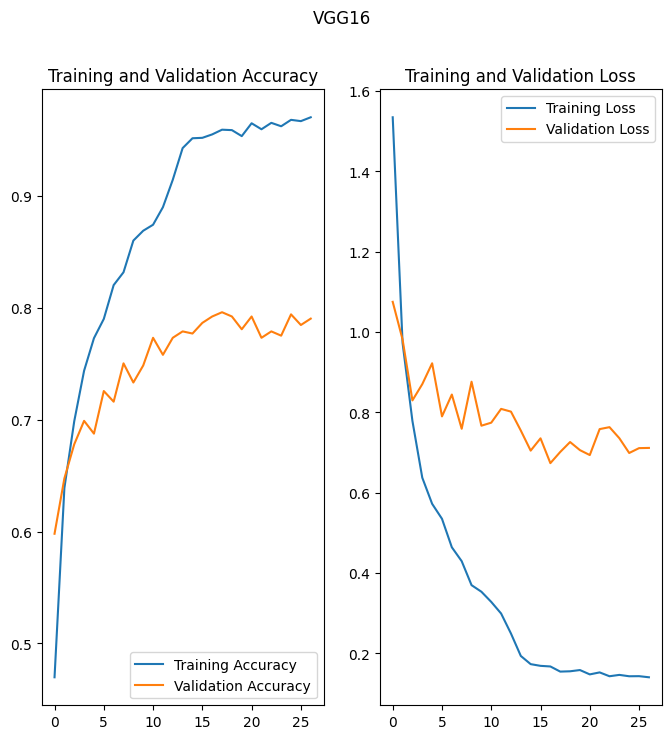

In [ ]:
# Plot history
plot_history(vgg_history, 'VGG16')

In [8]:
# Load best model
vgg_model = keras.models.load_model(os.path.join(model_dir, 'vgg_model.h5'))

In [ ]:
# Train and test accuracies
vgg_train_acc = vgg_model.evaluate(train_ds)
vgg_test_acc = vgg_model.evaluate(test_ds)
print('Train Accuracy: {:.2f}'.format(vgg_train_acc[1]))
print('Test Accuracy: {:.2f}'.format(vgg_test_acc[1]))

4/4 [==============================] - 1s 127ms/step - loss: 0.5934 - accuracy: 0.8125
Train Accuracy: 0.96
Test Accuracy: 0.81


In [10]:
# Generate predictions and labels
test_labels =  []
test_preds = []
for image, label in test_ds.unbatch():
  prediction = np.argmax(vgg_model.predict(np.expand_dims(image, 0), verbose=0))
  test_preds.append(prediction)
  test_labels.append(np.argmax(label))

In [ ]:
# Classification Report for VGG16
print(classification_report(test_labels, test_preds, target_names=class_labels))

              precision    recall  f1-score   support

        acne       1.00      1.00      1.00        13
      eczema       0.80      0.82      0.81        40
      fungal       0.87      0.79      0.83        34
   psoriasis       0.67      0.64      0.65        25
       warts       0.79      0.94      0.86        16

    accuracy                           0.81       128
   macro avg       0.83      0.84      0.83       128
weighted avg       0.81      0.81      0.81       128



In [12]:
# Defining function to plot confusion matrix
def plot_heatmap(y_true, y_pred, class_names, title):
    plt.figure(figsize=(10,10))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(
        cm,
        annot=True,
        square=True,
        xticklabels=class_names,
        yticklabels=class_names,
        fmt='d',
        cmap=plt.cm.Blues,
        cbar=True)

    plt.title(title, fontsize=16)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.show()

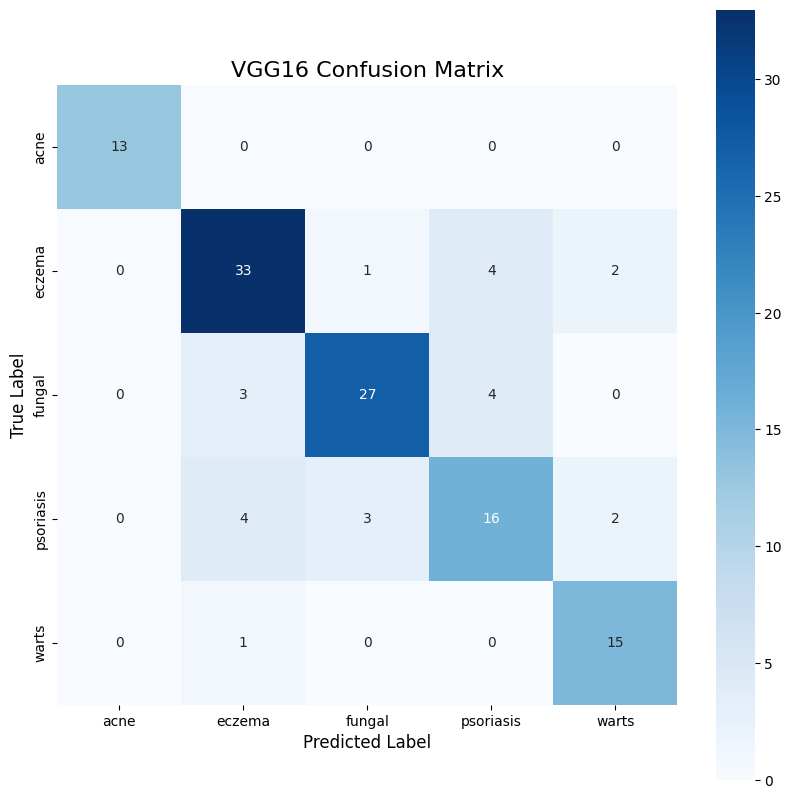

In [ ]:
# Confusion Matrix for VGG16
plot_heatmap(test_labels, test_preds, class_labels, title="VGG16 Confusion Matrix")

<a id='finetuning'></a>
## 5. Fine Tuning

In [ ]:
# Check base model layer names and trainable status
for layer in vgg_model.layers[4].layers:
  print(layer.name, layer.trainable)

input_3 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 False
block5_conv2 False
block5_conv3 False
block5_pool False


In [ ]:
# Set layers after block 5 to be trainable
start_layer_name = 'block5_conv1'
unfreeze=False

for layer in vgg_model.layers[4].layers:
  if start_layer_name in layer.name:
    unfreeze=True
  if unfreeze:
    if not isinstance(layer, layers.BatchNormalization):
      layer.trainable = True

In [ ]:
# Recheck that only layers after block 5 are trainable
for layer in vgg_model.layers[4].layers:
  print(layer.name, layer.trainable)

input_3 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 True
block5_conv2 True
block5_conv3 True
block5_pool True


In [ ]:
# Compile at a lower learning rate
vgg_model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4),
                   loss='categorical_crossentropy',
                   metrics=['accuracy']
                  )

In [ ]:
# Specify callbacks
callback_list = get_callbacks('vgg_fine.h5',
                              patience=6,
                              lr_factor=0.1)

# Fine tune model
vgg_fine_history = vgg_model.fit(train_ds,
                                 epochs=10,
                                 validation_data=val_ds,
                                 verbose=1,
                                 callbacks=callback_list)

Epoch 1/10
82/82 [==============================] - 18s 205ms/step - loss: 0.6140 - accuracy: 0.7634 - val_loss: 0.9091 - val_accuracy: 0.7200 - lr: 1.0000e-04
Epoch 2/10
82/82 [==============================] - 16s 194ms/step - loss: 0.3635 - accuracy: 0.8606 - val_loss: 0.8887 - val_accuracy: 0.7790 - lr: 1.0000e-04
Epoch 3/10
82/82 [==============================] - 15s 180ms/step - loss: 0.2816 - accuracy: 0.8982 - val_loss: 0.7712 - val_accuracy: 0.7657 - lr: 1.0000e-04
Epoch 4/10
82/82 [==============================] - 17s 199ms/step - loss: 0.2471 - accuracy: 0.9135 - val_loss: 0.7806 - val_accuracy: 0.7886 - lr: 1.0000e-04
Epoch 5/10
82/82 [==============================] - 16s 187ms/step - loss: 0.1764 - accuracy: 0.9364 - val_loss: 1.2659 - val_accuracy: 0.7733 - lr: 1.0000e-04
Epoch 6/10
82/82 [==============================] - ETA: 0s - loss: 0.1945 - accuracy: 0.9296
Epoch 6: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
82/82 [=======================

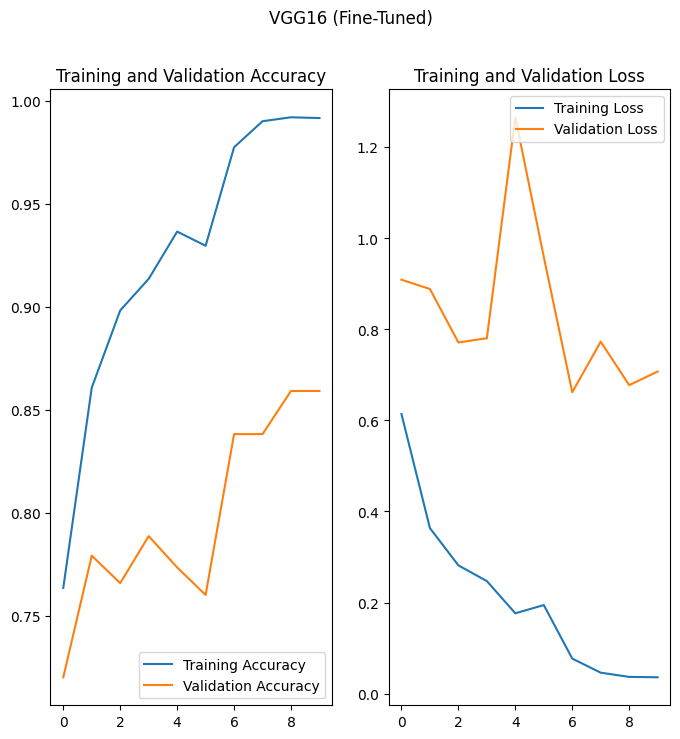

In [ ]:
# Plot history
plot_history(vgg_fine_history, 'VGG16 (Fine-Tuned)')

In [14]:
# Load best model
vgg_model = keras.models.load_model(os.path.join(model_dir, 'vgg_fine.h5'))

In [ ]:
# Train and test accuracies
vgg_fine_train_acc = vgg_model.evaluate(train_ds)
vgg_fine_test_acc = vgg_model.evaluate(test_ds)
print('Train Accuracy: {:.2f}'.format(vgg_fine_train_acc[1]))
print('Test Accuracy: {:.2f}'.format(vgg_fine_test_acc[1]))

4/4 [==============================] - 1s 130ms/step - loss: 0.7568 - accuracy: 0.8516
Train Accuracy: 0.99
Test Accuracy: 0.85


In [16]:
# Generate predictions and labels
test_labels =  []
test_preds = []
for image, label in test_ds.unbatch():
  prediction = np.argmax(vgg_model.predict(np.expand_dims(image, 0), verbose=0))
  test_preds.append(prediction)
  test_labels.append(np.argmax(label))

In [ ]:
# Classification Report for VGG16 (Fine-tuned)
print(classification_report(test_labels, test_preds, target_names=class_labels))

              precision    recall  f1-score   support

        acne       1.00      1.00      1.00         8
      eczema       0.90      0.90      0.90        49
      fungal       0.81      0.93      0.86        27
   psoriasis       0.76      0.59      0.67        22
       warts       0.87      0.91      0.89        22

    accuracy                           0.86       128
   macro avg       0.87      0.86      0.86       128
weighted avg       0.86      0.86      0.86       128



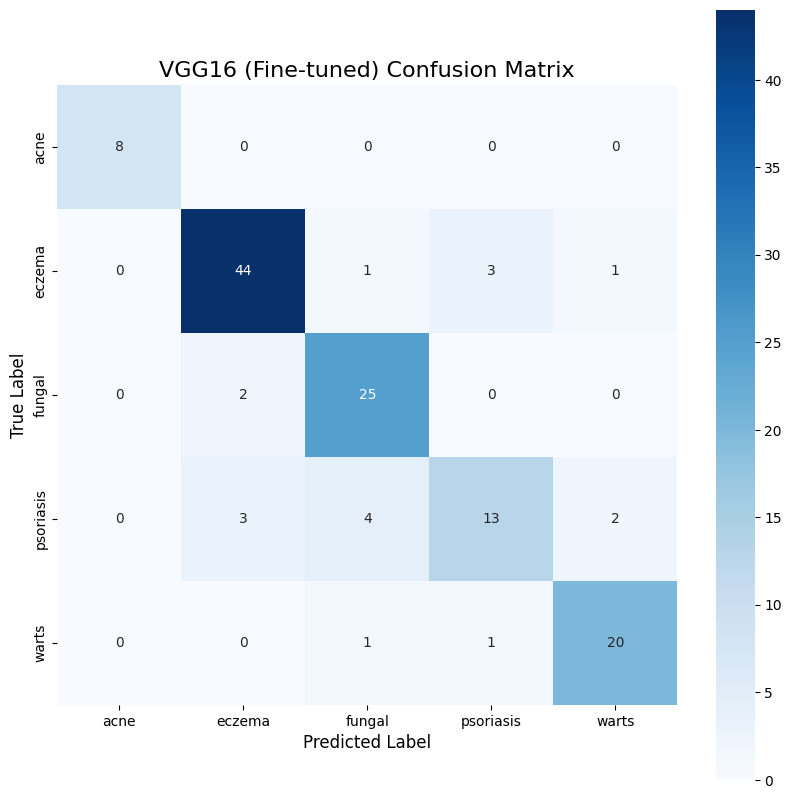

In [ ]:
# Confusion Matrix for VGG16 (Fine-tuned)
plot_heatmap(test_labels, test_preds, class_labels, title="VGG16 (Fine-tuned) Confusion Matrix")

### Models Summary

|Model|Train Accuracy|Test Accuracy|
|:---|:---:|:---|
|<b>EfficientNetB1 (Baseline Model)</b>|0.89|0.78|
|<b>EfficientNetB1 Fine-Tuned</b>|0.93|0.88|
|<b>VGG16</b>|0.96|0.81|
|<b>VGG16 Fine-Tuned|0.99|0.85|